In [1]:
!pip install -q torch torchvision diffusers transformers accelerate safetensors peft bitsandbytes

import torch
import os
import gc
from google.colab import drive
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer, BitsAndBytesConfig
from peft import PeftModel
from PIL import Image
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.8 MB/s eta 0:00:00


In [2]:
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_MODEL_PATH = "/content/drive/MyDrive/sdxl-base-1.0"
LORA_WEIGHTS_PATH = "/content/drive/MyDrive/Naruto_FineTune/final_weights"

In [4]:
prompts = [
    "Naruto Uzumaki eating ramen",
    "Bill Gates in Naruto style",
    "A boy with blue eyes in Naruto style",
]

# Helper to clear memory
def flush():
    gc.collect()
    torch.cuda.empty_cache()

In [5]:
def generate_image(prompt, use_lora=False):
    print(f"\n Generating ({'Fine-Tuned' if use_lora else 'Original'}): '{prompt}'")
    flush()

    # Define 4-bit Quantization Config (Matches Training)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    print("   Loading components...")
    tokenizer = CLIPTokenizer.from_pretrained(BASE_MODEL_PATH, subfolder="tokenizer")
    tokenizer_2 = CLIPTokenizer.from_pretrained(BASE_MODEL_PATH, subfolder="tokenizer_2")
    text_encoder = CLIPTextModel.from_pretrained(BASE_MODEL_PATH, subfolder="text_encoder", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
    text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(BASE_MODEL_PATH, subfolder="text_encoder_2", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
    vae = AutoencoderKL.from_pretrained(BASE_MODEL_PATH, subfolder="vae", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
    scheduler = DDPMScheduler.from_pretrained(BASE_MODEL_PATH, subfolder="scheduler")

    # Load UNet in 4-bit (QLoRA)
    # Note: We have to load it via the class first to apply quantization
    print("   Loading UNet in 4-bit...")
    unet_path = os.path.join(BASE_MODEL_PATH, "unet")
    unet = UNet2DConditionModel.from_pretrained(
        unet_path,
        quantization_config=bnb_config, # <--- Critical for Exp 2
        torch_dtype=torch.float16,
        device_map="auto"
    )

    # Assemble Pipeline
    pipe = StableDiffusionXLPipeline(
        vae=vae, text_encoder=text_encoder, text_encoder_2=text_encoder_2,
        tokenizer=tokenizer, tokenizer_2=tokenizer_2, unet=unet, scheduler=scheduler
    )

    # Optimize Inference
    pipe.enable_vae_slicing()

    # Inject LoRA (If Fine-Tuned)
    if use_lora:
        try:
            print("   Attaching LoRA weights (No Merge)...")

            pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_WEIGHTS_PATH)
            # Note: pipe.unet.merge_and_unload() is REMOVED because the base is quantized
        except Exception as e:
            print(f"    Error loading LoRA: {e}")
            return None

    # Generate
    generator = torch.Generator("cuda").manual_seed(42)
    image = pipe(
        prompt=prompt,
        num_inference_steps=30,
        guidance_scale=7.5,
        generator=generator
    ).images[0]

    # Cleanup
    del pipe, unet, vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, scheduler
    flush()

    return image


PROMPT: Naruto Uzumaki eating ramen

 Generating (Original): 'Naruto Uzumaki eating ramen'
   Loading components...


`torch_dtype` is deprecated! Use `dtype` instead!


   Loading UNet in 4-bit...


  0%|          | 0/30 [00:00<?, ?it/s]


 Generating (Fine-Tuned): 'Naruto Uzumaki eating ramen'
   Loading components...
   Loading UNet in 4-bit...
   Attaching LoRA weights (No Merge)...


  0%|          | 0/30 [00:00<?, ?it/s]


--- RESULT (Left: Original | Right: Fine-Tuned) ---


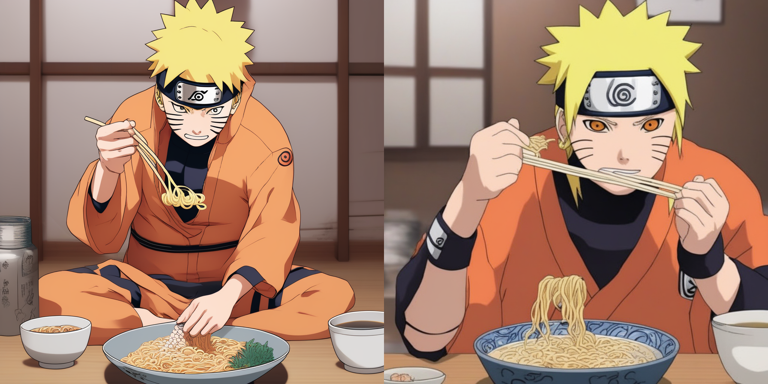


PROMPT: Bill Gates in Naruto style

 Generating (Original): 'Bill Gates in Naruto style'
   Loading components...
   Loading UNet in 4-bit...


  0%|          | 0/30 [00:00<?, ?it/s]


 Generating (Fine-Tuned): 'Bill Gates in Naruto style'
   Loading components...
   Loading UNet in 4-bit...
   Attaching LoRA weights (No Merge)...


  0%|          | 0/30 [00:00<?, ?it/s]


--- RESULT (Left: Original | Right: Fine-Tuned) ---


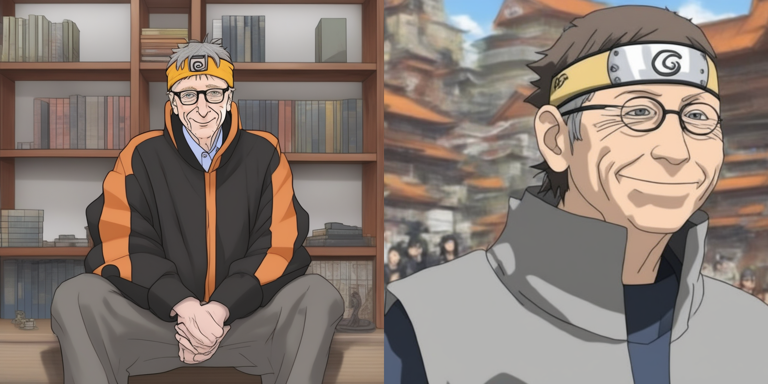


PROMPT: A boy with blue eyes in Naruto style

 Generating (Original): 'A boy with blue eyes in Naruto style'
   Loading components...
   Loading UNet in 4-bit...


  0%|          | 0/30 [00:00<?, ?it/s]


 Generating (Fine-Tuned): 'A boy with blue eyes in Naruto style'
   Loading components...
   Loading UNet in 4-bit...
   Attaching LoRA weights (No Merge)...


  0%|          | 0/30 [00:00<?, ?it/s]


--- RESULT (Left: Original | Right: Fine-Tuned) ---


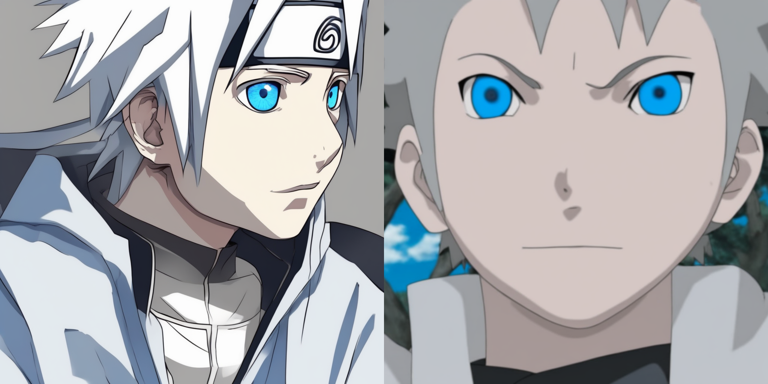

In [6]:
for prompt in prompts:
    print(f"\n" + "="*50)
    print(f"PROMPT: {prompt}")
    print("="*50)

    image_base = generate_image(prompt, use_lora=False)
    image_tuned = generate_image(prompt, use_lora=True)

    if image_base and image_tuned:
        total_width = image_base.width + image_tuned.width
        combined = Image.new('RGB', (total_width, image_base.height))
        combined.paste(image_base, (0, 0))
        combined.paste(image_tuned, (image_base.width, 0))

        print("\n--- RESULT (Left: Original | Right: Fine-Tuned) ---")
        display(combined.resize((768, 384)))